# This notebook shows how to use `autodp` to track differential privacy losses.

## 1. Installation and import
Simply type in the terminal
`pip install autodp`

In [7]:
# Import package
from autodp import rdp_bank, rdp_acct, dp_acct,privacy_calibrator


## 2. Declare the data structure for tracking privacy loss

`autodp` has two privacy loss trackers:  `dp_acct.DP_Acct` that tracks a fixed sequence of $(\epsilon,\delta)$ and `rdp_acct.anaRDPacct` that tracks the entire family of $(\epsilon,\delta)$ through the analytical expression of the Renyi Differential Privacy, or (up to scaling) equivalently, the CGF (log-MGF) of the privacy random variable:
$$
\log\Big(\frac{p(x)}{q(x)}\Big)
$$
induces ed by $x\sim p$.

We will be mostly demostrating the latter for now.

In [8]:
# declare the moment accountants
acct = rdp_acct.anaRDPacct()

## 3. Obtain an analytical RDP for popular privacy mechanisms using `rdp_bank`

The input to `anRDPacct` is in fact lambda functions that output the evaluations of the CGF that comes from.

To make our lives easy, `rdp_bank` implements the CCF of most popular differentially private algorithms
    * Laplace mechanism
    * Gaussian mechanism
    * Randomized response
    * pDP of two Multivariate Gaussians
    * pDP of two Exponential Family

Each of these would take a set of parameters as input in a dictionary form. For example, the Gaussian mechanism will take the ratio between the noise std and the L2 sensitivity of the function to be released.

In [9]:
# A few example of these lambda functions here

sigma = 5.0
b = 2.0
p = 0.7

# get the CGF functions
func_gaussian = lambda x: rdp_bank.RDP_gaussian({'sigma': sigma}, x)
func_laplace = lambda x: rdp_bank.RDP_laplace({'b': b}, x)
func_randresp = lambda x: rdp_bank.RDP_randresponse({'p':p},x)



## 4. Now mix and match and track their RDP using `anaRDPacct.compose_mechanism` and get the smallest $\epsilon$ for your chosen $\delta$

In [10]:
acct.compose_mechanism(func_randresp)
delta = 0

print('Pure DP of \eps = '+ repr(acct.get_eps(delta)) + ', after the RandResp.')

acct.compose_mechanism(func_laplace)
print('Pure DP of \eps = '+ repr(acct.get_eps(delta)) + ', after the RandResp + Laplace.')

acct.compose_mechanism(func_gaussian)
print('Pure DP of \eps = '+ repr(acct.get_eps(delta)) + ', after the RandResp + Laplace + Gaussian.')
delta = 1e-6
print('Approx. DP with \eps = '+ repr(acct.get_eps(delta)) + ', \delta =' + repr(delta) + 
      ' after the RandResp + Laplace + Gaussian.')



Pure DP of \eps = 0.8472978603872034, after the RandResp.
Pure DP of \eps = 1.3472978603872034, after the RandResp + Laplace.
Pure DP of \eps = inf, after the RandResp + Laplace + Gaussian.
Approx. DP with \eps = 2.3570174762458844, \delta =1e-06 after the RandResp + Laplace + Gaussian.


## 5. An additional feature that is supported by `autodp` is that we can do **subsampled-mechanisms** for anything that the RDP is available in closed form.

This can be achieved by `anaRDPacct.compose_subsampled_mechanism`


Composed privacy loss is (0.08233248043071076, 0.062310000409198776, 0.04225026425059442)
Composed privacy loss is (0.10277444534521885, 0.08266453082236774, 0.06255461629951665)
Composed privacy loss is (0.1230787973941411, 0.10296888287129, 0.08281832183164091)
Composed privacy loss is (0.1433831494487865, 0.12321743298513416, 0.10135478188736624)
Composed privacy loss is (0.16361654413862742, 0.14252994134403232, 0.1167131099330812)
Composed privacy loss is (0.1833299229639482, 0.15933532353864083, 0.130105108813539)
Composed privacy loss is (0.2010347346977478, 0.17435642435662455, 0.1421356041348414)
Composed privacy loss is (0.21713275903871893, 0.18806530795846288, 0.15315068070964788)
Composed privacy loss is (0.23199727392616082, 0.20075677672145145, 0.16337276347435165)
Composed privacy loss is (0.24587608093967792, 0.2126281618094027, 0.1729478287895257)
Composed privacy loss is (0.2589424647574089, 0.22382154322697878, 0.1819878031555071)
Composed privacy loss is (0.2713249

Composed privacy loss is (0.7753301116037821, 0.6695202422132549, 0.5446283372304586)
Composed privacy loss is (0.7792874477935193, 0.6729285746490432, 0.5474204198282007)
Composed privacy loss is (0.7832295686453506, 0.6763369071593824, 0.5502125024206765)
Composed privacy loss is (0.7871716889383431, 0.6797452390039709, 0.5530045847985173)
Composed privacy loss is (0.7911138099869035, 0.6831535719564077, 0.5557966674732047)
Composition of 1000 subsampled Gaussian mechanisms gives  (0.6862210711486171, 1e-06)


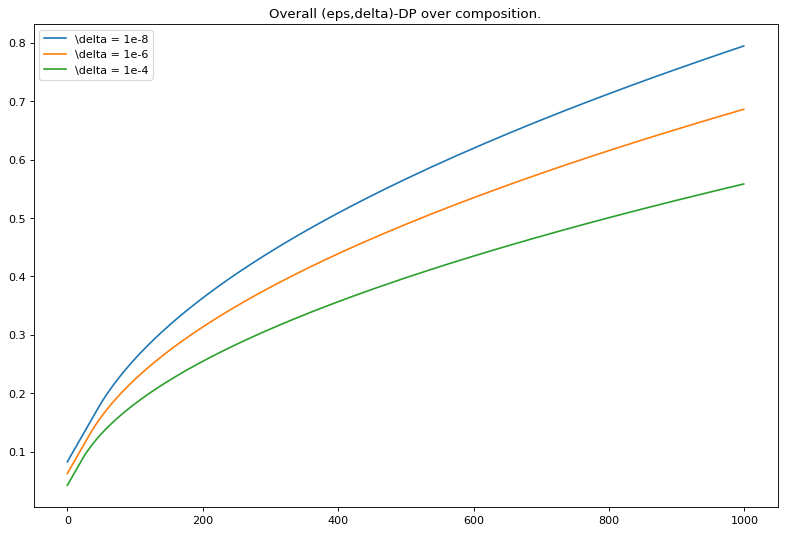

In [15]:
# decalre another moment accountant
acct2 = rdp_acct.anaRDPacct()
eps_seq = []
eps_seq2= []
eps_seq3= []

delta1 = 1e-8
delta2 = 1e-6
delta3 = 1e-4

sigma = 5.0
func = lambda x: rdp_bank.RDP_gaussian({'sigma': sigma}, x)
k=1000
prob = 0.01
for i in range(k):
    acct2.compose_subsampled_mechanism(func,prob)
    eps_seq.append(acct2.get_eps(delta1))
    eps_seq2.append(acct2.get_eps(delta2))
    eps_seq3.append(acct2.get_eps(delta3))
    if i%100==0:
        print("[",i,"]Privacy loss is",(eps_seq[-1],eps_seq2[-1],eps_seq3[-1]))


print("Composition of 1000 subsampled Gaussian mechanisms gives ", (acct2.get_eps(delta), delta))

import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(num=1, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(k), eps_seq)
plt.plot(range(k), eps_seq2)
plt.plot(range(k), eps_seq3)

plt.legend(['\delta = 1e-8', '\delta = 1e-6', '\delta = 1e-4'], loc='best')
plt.title('Overall (eps,delta)-DP over composition.')
plt.show()